In [6]:
#!pip install qiskit
#!pip install qiskit_finance

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumRegister, QuantumCircuit, execute, AncillaRegister, transpile
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

In [14]:
# to represent the two different underlyings, we map them to different dimensions
# this variable represents the number of uncertainty qubits per dimension
num_uncertainty_qubits = 2

# same parameters from European calls and puts
spot = 2.0  
vol = 0.2 
rate = 0.05  
T = 100 / 365  # 100 days till options expiry

# resulting parameters for log-normal distribution
mu = (rate - 0.5 * vol ** 2) * T + np.log(spot)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# lowest and highest spot prices considered
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev


# for simplicity in our use case, we'll say that they both have the same prob. dist.
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma ** 2 * np.eye(dimension)

# constructing the circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

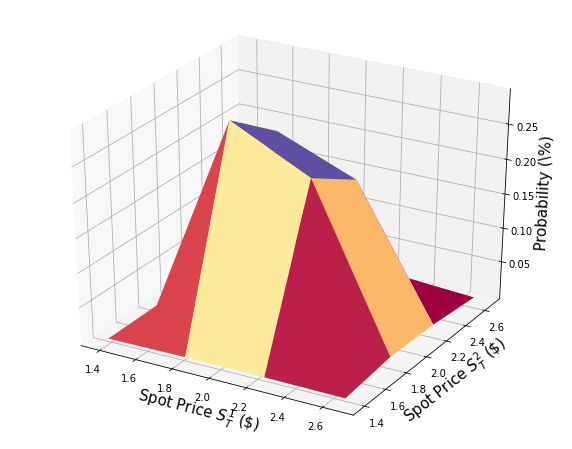

In [15]:
# plotting the uncertainty model into a PDF
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
resolution = np.array([2 ** n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=15)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=15)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

In [16]:
# to integrate with the quantum adder circuit over the integers,
# we need to map our expected spots to integer values, and then
# convert them back. Here we calculate the # of qubits needed to do so

weights = []
for n in num_qubits:
  for i in range(n):
    weights += [2 ** i]

# aggregating circuit
agg = WeightedAdder(sum(num_qubits), weights)
n_s = agg.num_sum_qubits                             # num of summation qubits from the adder
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # num auxilliary qubits

In [17]:
strike_price = 3.40

# mapping the strike price from the real #'s to integer values over # qubits
max_value = 2 ** n_s - 1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - dimension * low_) / (high_ - low_) * (2 ** num_uncertainty_qubits - 1)
)

# approximation error
c_approx = 0.25

#creating a piecewise linear function that only pays
# max(S1 + S2 - K, 0)
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2 ** num_uncertainty_qubits - 1) - mapped_strike_price
basket_objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [18]:
# define the problem in a formal framework
qr_state = QuantumRegister(u.num_qubits, "state")  # loads the prob. dist.
qr_obj = QuantumRegister(1, "obj")                 # encodes function values
ar_sum = AncillaRegister(n_s, "sum")               # # of qubits used to encode the sum
ar = AncillaRegister(max(n_aux, basket_objective.num_ancillas), "work")  # additional ancilla qubits

objective_index = u.num_qubits # qubit in which our answer lies

#constructing the circuit
basket_option = QuantumCircuit(qr_state, qr_obj, ar_sum, ar)
basket_option.append(u, qr_state)
basket_option.append(agg, qr_state[:] + ar_sum[:] + ar[:n_aux])
basket_option.append(basket_objective, ar_sum[:] + qr_obj[:] + ar[: basket_objective.num_ancillas])

print(basket_option.draw())
print("objective qubit index", objective_index)

         ┌───────┐┌────────┐      
state_0: ┤0      ├┤0       ├──────
         │       ││        │      
state_1: ┤1      ├┤1       ├──────
         │  P(X) ││        │      
state_2: ┤2      ├┤2       ├──────
         │       ││        │      
state_3: ┤3      ├┤3       ├──────
         └───────┘│        │┌────┐
    obj: ─────────┤        ├┤3   ├
                  │        ││    │
  sum_0: ─────────┤4 adder ├┤0   ├
                  │        ││    │
  sum_1: ─────────┤5       ├┤1   ├
                  │        ││    │
  sum_2: ─────────┤6       ├┤2 F ├
                  │        ││    │
 work_0: ─────────┤7       ├┤4   ├
                  │        ││    │
 work_1: ─────────┤8       ├┤5   ├
                  │        ││    │
 work_2: ─────────┤9       ├┤6   ├
                  └────────┘└────┘
objective qubit index 4


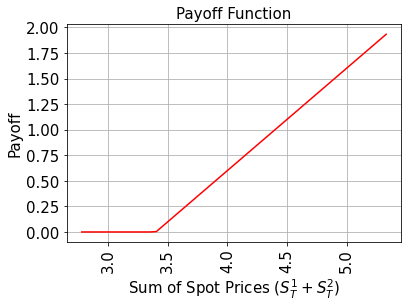

In [19]:
# plotting the exact payoff function
x = np.linspace(sum(low), sum(high))
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Sum of Spot Prices ($S_T^1 + S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [20]:
# evaluate exact expected value
sum_values = np.sum(u.values, axis=1)
exact_value = np.dot(
    u.probabilities[sum_values >= strike_price],
    sum_values[sum_values >= strike_price] - strike_price,
)
print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.6317


In [23]:
num_state_qubits = basket_option.num_qubits - basket_option.num_ancillas # # of qubits that encodes the state
print("state qubits: ", num_state_qubits)
transpiled = transpile(basket_option, basis_gates=["u", "cx"])
print("circuit width:", transpiled.width())
print("circuit depth:", transpiled.depth())

state qubits:  5
circuit width: 11
circuit depth: 403


In [24]:
# running the circuit
job = execute(basket_option, backend=Aer.get_backend("statevector_simulator"))

In [25]:
# evaluating the statevector we get from the job
value = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % num_state_qubits).format(i)[-num_state_qubits:]
    prob = np.abs(a) ** 2
    if prob > 1e-4 and b[0] == "1":
        value += prob

# undoing the earlier integer mapping
mapped_value = (
    basket_objective.post_processing(value) / (2 ** num_uncertainty_qubits - 1) * (high_ - low_)
)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % mapped_value)
print("Exact Expected Payoff: %.4f" % exact_value)

Exact Operator Value:  0.4327
Mapped Operator value: 0.6351
Exact Expected Payoff: 0.6317


In [26]:
# using amplitude estimation to recover the payoff

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=basket_option,
    objective_qubits=[objective_index],
    post_processing=basket_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [27]:
result = ae.estimate(problem)

In [28]:
# check our confidence interval

conf_int = (
    np.array(result.confidence_interval_processed)
    / (2 ** num_uncertainty_qubits - 1)
    * (high_ - low_)
)
print("Exact value:        \t%.4f" % exact_value)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed / (2 ** num_uncertainty_qubits - 1) * (high_ - low_))
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.6317
Estimated value:    	0.6374
Confidence interval:	[0.5915, 0.6833]
